In [1]:
import pandas as pd
import QuantLib as ql
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Description
Example of EONIA curve construction as provided in _Ballabio, Balaraman: QuantLib Python Cookbook, 2017), chapter 6_. 

This is similar as the curve construction problem in 
_F. M. Ametrano and M. Bianchetti, Everything You Always Wanted to Know About Multiple Interest Rate Curve Bootstrapping but Were Afraid to Ask, 2013_

The EONIA curve is constructed from:
- 1-day deposit rates on the short end
- OIS rates afterwards

In [12]:
# conversion of python date to QuantLib date
def dt_to_ql_Date(dt): return ql.Date(dt.day, dt.month, dt.year)

# Set today's (`2012-12-11`) date

In [13]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

# Get input data
Depo, OIS and forward-starting OIS

In [14]:
def strpdate(datestring): return datetime.strptime(datestring[3:].strip(),'%d %b %Y')

data = pd.read_excel('data/EONIA_construction_inputs.xlsx', sheet_name = 'EONIA')
data['start_date'] = data['start_date'].apply(strpdate)
data['end_date']   = data['end_date'].apply(strpdate)
data['today']      = pd.to_datetime(today.to_date())
data

,instrument,rate,start_date,end_date,rate_type,today
0,EUR YC OND,0.00040,2012-12-11,2012-12-12,depo,2012-12-11
1,EUR YC TND,0.00040,2012-12-12,2012-12-13,depo,2012-12-11
2,EUR YC SND,0.00040,2012-12-13,2012-12-14,depo,2012-12-11
3,EUR YC EON1W,0.00070,2012-12-13,2012-12-20,ois,2012-12-11
4,EUR YC EON2W,0.00069,2012-12-13,2012-12-27,ois,2012-12-11
5,EUR YC EON3W,0.00078,2012-12-13,2013-01-03,ois,2012-12-11
6,EUR YC EON1M,0.00074,2012-12-13,2013-01-14,ois,2012-12-11
7,EUR YC EONECBJAN13,0.00046,2013-01-16,2013-02-13,forward_starting_ois,2012-12-11
8,EUR YC EONECBEEB13,0.00016,2013-02-13,2013-03-13,forward_starting_ois,2012-12-11
9,EUR YC EONECBMAR13,-0.00007,2013-03-13,2013-04-10,forward_starting_ois,2012-12-11


# Deposit curves helpers

In [15]:
depo_cash_rates                           = data.query('rate_type == "depo"').copy()
depo_cash_rates['fixing_days_from_today'] = (depo_cash_rates['start_date']-depo_cash_rates['today']).dt.days
depo_cash_rates['tenor_days']             = (depo_cash_rates['end_date']  -depo_cash_rates['start_date']).dt.days

helpers_depo = [ ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate)), ql.Period(tenor_days,ql.Days), fixingDays, ql.TARGET(), ql.Following, False, ql.Actual360()) 
                 for rate, tenor_days, fixingDays in zip(depo_cash_rates['rate'],depo_cash_rates['tenor_days'],depo_cash_rates['fixing_days_from_today']) ]

depo_cash_rates

,instrument,rate,start_date,end_date,rate_type,today,fixing_days_from_today,tenor_days
0,EUR YC OND,0.0004,2012-12-11,2012-12-12,depo,2012-12-11,0,1
1,EUR YC TND,0.0004,2012-12-12,2012-12-13,depo,2012-12-11,1,1
2,EUR YC SND,0.0004,2012-12-13,2012-12-14,depo,2012-12-11,2,1


# OIS swap helpers

In [16]:
ois_rates = data.query('rate_type != "depo"').copy()
ois_rates

,instrument,rate,start_date,end_date,rate_type,today
3,EUR YC EON1W,0.00070,2012-12-13,2012-12-20,ois,2012-12-11
4,EUR YC EON2W,0.00069,2012-12-13,2012-12-27,ois,2012-12-11
5,EUR YC EON3W,0.00078,2012-12-13,2013-01-03,ois,2012-12-11
6,EUR YC EON1M,0.00074,2012-12-13,2013-01-14,ois,2012-12-11
7,EUR YC EONECBJAN13,0.00046,2013-01-16,2013-02-13,forward_starting_ois,2012-12-11
8,EUR YC EONECBEEB13,0.00016,2013-02-13,2013-03-13,forward_starting_ois,2012-12-11
9,EUR YC EONECBMAR13,-0.00007,2013-03-13,2013-04-10,forward_starting_ois,2012-12-11
10,EUR YC EONECBAP13,-0.00013,2013-04-10,2013-05-08,forward_starting_ois,2012-12-11
11,EUR YC EONECBMAY13,-0.00014,2013-05-08,2013-06-12,forward_starting_ois,2012-12-11
12,EUR YC EON15M,0.00002,2012-12-13,2014-03-13,ois,2012-12-11


In [17]:
# OIS helpers
ois_helpers = [ ql.DatedOISRateHelper(dt_to_ql_Date(start_date), dt_to_ql_Date(end_date), ql.QuoteHandle(ql.SimpleQuote(rate)), ql.Eonia()) 
                for (rate, start_date, end_date) in ois_rates[['rate', 'start_date', 'end_date']].values]

# Build curve from helpers

In [18]:
# use helpers and Piecewise to build the curve
eonia_curve_c = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), helpers_depo + ois_helpers, ql.Actual365Fixed())
eonia_curve_c.enableExtrapolation()

# Display built curves

In [19]:
end            = today + ql.Period(2,ql.Years)
dates          = [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1) ]
dates_plot     = [ql.Date(serial).to_date() for serial in range(today.serialNumber(), end.serialNumber()+1)]
rates_fwd      = [eonia_curve_c.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate() for d in dates ]

rates_zero     = [eonia_curve_c.zeroRate(d, ql.Actual360(), ql.Continuous).rate() for d in dates]
discount_curve = [eonia_curve_c.discount(d) for d in dates]

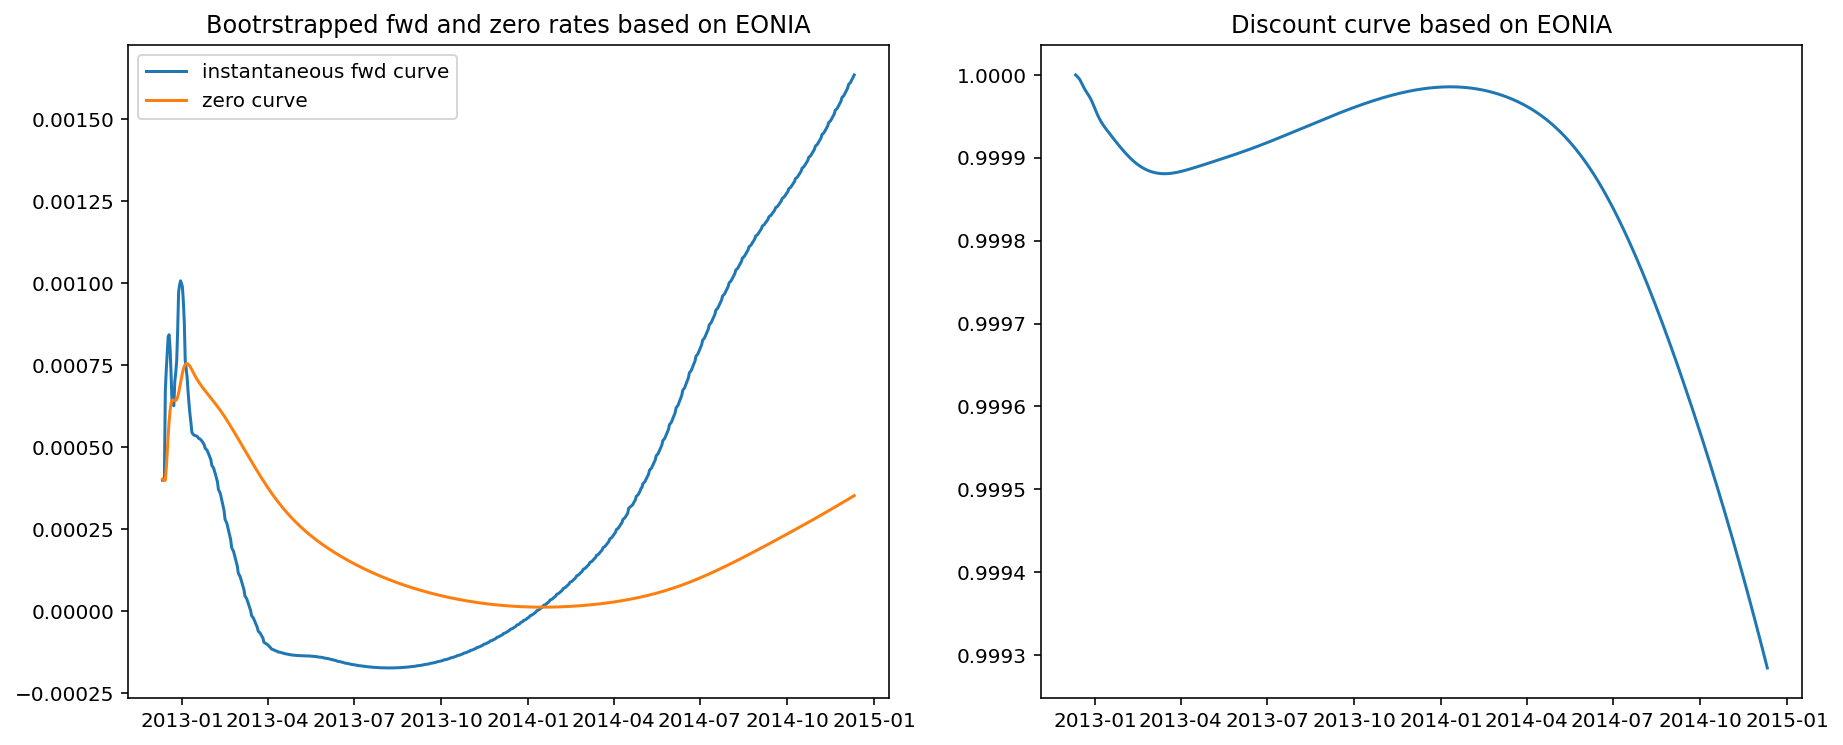

In [34]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))

ax[0].plot(dates_plot, rates_fwd,  label = 'instantaneous fwd curve');
ax[0].plot(dates_plot, rates_zero, label = 'zero curve');
ax[0].legend();
ax[0].set_title('Bootrstrapped fwd and zero rates based on EONIA');

ax[1].plot(dates_plot, discount_curve)
ax[1].set_title('Discount curve based on EONIA');